In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
import matplotlib.pyplot as plt

from sklearn import preprocessing

**Import Dataset**

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
path = "/content/drive/MyDrive/Fintech Proj 1/NVDA.csv"
df_NVDA = pd.read_csv(path)

In [ ]:
#Get prices from 2019 onwards
df_NVDA = df_NVDA[(df_NVDA['Date'] > '2019-01-01')]
df_NVDA

,Date,Open,High,Low,Close,Adj Close,Volume
5017,2019-01-02,32.660000,34.619999,32.512501,34.055000,33.814121,50875200
5018,2019-01-03,33.447498,33.790001,31.922501,31.997499,31.771172,70555200
5019,2019-01-04,32.735001,34.432499,32.424999,34.047501,33.806683,58562000
5020,2019-01-07,34.625000,36.222500,34.107498,35.849998,35.596416,70916000
5021,2019-01-08,36.672501,36.695000,34.224998,34.957500,34.710243,78601600
...,...,...,...,...,...,...,...
5972,2022-10-17,115.180000,119.480003,115.169998,118.879997,118.879997,58077400
5973,2022-10-18,123.440002,124.919998,116.180000,119.669998,119.669998,65936200
5974,2022-10-19,118.790001,123.500000,118.339996,120.510002,120.510002,52313100
5975,2022-10-20,121.129997,127.690002,121.050003,121.940002,121.940002,65239800


**Data Preprocessing**

In [ ]:
closePrice = df_NVDA['Close'].to_numpy()

In [ ]:
features = np.array(closePrice).reshape(-1,1)

In [ ]:
#Apply Min-Max scaling on data
scaler = preprocessing.MinMaxScaler().fit(features)
scaled_features = scaler.transform(features)

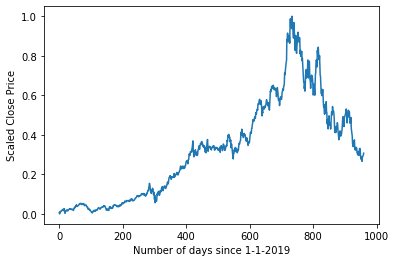

In [ ]:
#Plot of data to be trained on
for i in range(len(scaled_features[0])):
  plt.plot(scaled_features[...,i], label= i)
  plt.xlabel("Number of days since 1-1-2019")
  plt.ylabel("Scaled Close Price")

In [ ]:
#Generating input data
#30 consecutive days of closing prices is used to predict closing price 10 days later from the last day in the input
#input vector x has a shape of (rows, 30, 1)
#output vector y has a shape of (rows, 1)
sampleLength = 30
forecast_days = 10
x = []
y = []
for i in range(len(closePrice)-sampleLength-forecast_days):
  x += [scaled_features[i:i+sampleLength]]
  y += [closePrice[i+sampleLength+forecast_days-1]]

x = np.array(x)
y = np.array(y)

y = y[..., np.newaxis]
#x = x[np.newaxis, :]

In [ ]:
#Train-Test split: last 50 days in dataset used for testing
testLen = 50
trainLen = len(x) - testLen
trainX, trainY, testX, testY = x[:trainLen], y[:trainLen], x[trainLen:], y[trainLen:]

**Building and fitting the Model**

The model consist of 4 LSTM layers with a BatchNormalization and Dropout layer after each of them. A dense layer is used to output the data.

In [ ]:

model = Sequential([
    LSTM(50, input_shape=(sampleLength,features.shape[1]), return_sequences = True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(50, return_sequences = True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(50, return_sequences = True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(50),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="linear")
])

opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mse"]
)
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_99 (LSTM)              (None, 30, 50)            10400     
                                                                 
 batch_normalization_20 (Bat  (None, 30, 50)           200       
 chNormalization)                                                
                                                                 
 dropout_96 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_100 (LSTM)             (None, 30, 50)            20200     
                                                                 
 batch_normalization_21 (Bat  (None, 30, 50)           200       
 chNormalization)                                                
                                                                 
 dropout_97 (Dropout)        (None, 30, 50)          

In [ ]:
#Early Stopping Callback used to identify epoch with minimum validation loss
callbacks = [tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights = True)]

In [ ]:
#Final weights were obtained after training 60 epochs without early stopping, then 30 with early stopping.
history = model.fit(
    trainX, 
    trainY,
    validation_data = (testX, testY),
    epochs = 60,
    batch_size = 32,
    callbacks = callbacks
)

Epoch 1/60
28/28 [==============================] - 2s 81ms/step - loss: 993.1409 - mse: 993.1409 - val_loss: 425.3680 - val_mse: 425.3680
Epoch 2/60
28/28 [==============================] - 2s 76ms/step - loss: 848.5571 - mse: 848.5571 - val_loss: 661.4269 - val_mse: 661.4269
Epoch 3/60
28/28 [==============================] - 2s 77ms/step - loss: 752.8335 - mse: 752.8335 - val_loss: 297.9260 - val_mse: 297.9260
Epoch 4/60
28/28 [==============================] - 2s 77ms/step - loss: 942.0097 - mse: 942.0097 - val_loss: 264.4593 - val_mse: 264.4593
Epoch 5/60
28/28 [==============================] - 2s 76ms/step - loss: 782.4086 - mse: 782.4086 - val_loss: 1627.9164 - val_mse: 1627.9164
Epoch 6/60
28/28 [==============================] - 2s 77ms/step - loss: 799.4814 - mse: 799.4814 - val_loss: 323.1363 - val_mse: 323.1363
Epoch 7/60
28/28 [==============================] - 2s 76ms/step - loss: 697.6027 - mse: 697.6027 - val_loss: 344.3234 - val_mse: 344.3234
Epoch 8/60
28/28 [=======

**Plot of actual closing price together with predicted closing price for training data**

28/28 [==============================] - 1s 21ms/step


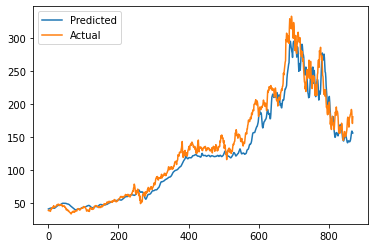

In [ ]:
predicted = model.predict(trainX)
plt.plot(predicted, label = 'Predicted')
plt.plot(trainY, label = 'Actual')
plt.legend(loc="upper left")

**Actual closing price together with predicted closing price for testing data**




2/2 [==============================] - 0s 23ms/step


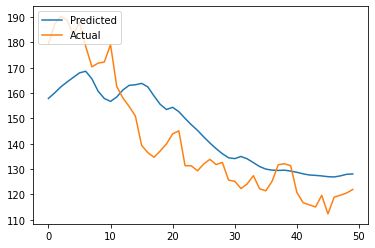

In [ ]:
predicted = model.predict(testX)
plt.plot(predicted, label = 'Predicted')
plt.plot(testY, label = 'Actual')
plt.legend(loc="upper left")

In [ ]:
model.save("/content/drive/MyDrive/Fintech Proj 1")

Forecasting Closing Prices for 24 October - 4 November (10 trading days) 

In [ ]:
forecast_input = []
for i in range(len(closePrice)-sampleLength-forecast_days, len(closePrice)-sampleLength):
  forecast_input += [scaled_features[i:i+sampleLength]]

forecast_input = np.array(forecast_input)

In [ ]:
output_prediction = model.predict(forecast_input)

1/1 [==============================] - 0s 54ms/step


In [ ]:
pd.DataFrame(output_prediction).to_csv("Tiong Jackson_implementation_1")

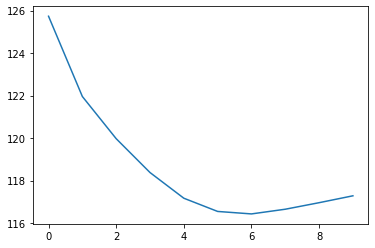

In [ ]:
plt.plot(output_prediction)